## 1.3 Concatenate and visualize


We have downloaded 175 netcdf files, that we will compile into one netcdf file here. Also we will plot the modeled and observed precipitation.

### Import packages

In [90]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [91]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


In [4]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory
os.chdir(pwd+'/../../') # Change the working directory to UNSEEN-open
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open/Notebooks/1.Download'

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

## Concatenate

Here we will create an netcdf file that contains the dimensions lat, lon, number (25 ensembles), time (35 years) and leadtime (5 initialization months). We loop over lead times, and open all 35 years of the lead time and then concatenate those leadtimes. 

In [22]:
init_months = np.append(np.arange(9,13),1) ## Initialization months 9-12,1 (Sep-Jan)


array([ 1, 12, 11, 10,  9])

In [113]:
SEAS5_ld1= xr.open_mfdataset('../UK_example/SEAS5/' + '*01.nc', combine='by_coords') # Load the first lead time 
SEAS5= SEAS5_ld1 # Create the xarray dataset to concatenate over
for init_month in init_months[0:-1][::-1]: ## Remove the first that we already have and invert so it is lead time 1-5
    print(init_month)
    SEAS5_ld = xr.open_mfdataset('../UK_example/SEAS5/' + '*' +  "%.2i" % init_month + '.nc', combine='by_coords') # Load the first lead time to concatenate over
    SEAS5=xr.concat([SEAS5,SEAS5_ld],dim='leadtime') 


12
11
10
9


In [114]:
SEAS5 = SEAS5.assign_coords(leadtime = np.arange(5) + 1) # assign leadtime coordinates
SEAS5['tprate'] = SEAS5['tprate'] * 1000 * 3600 * 24 ## From m/s to mm/d
SEAS5['tprate'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}
SEAS5.load()

<xarray.Dataset>
Dimensions:    (latitude: 11, leadtime: 5, longitude: 14, number: 25, time: 35)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0
  * time       (time) datetime64[ns] 1982-02-01 1983-02-01 ... 2016-02-01
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * leadtime   (leadtime) int64 1 2 3 4 5
Data variables:
    tprate     (leadtime, time, number, latitude, longitude) float32 4.051119 ... 2.0141993
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-13 14:49:43 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## Visualize

Here I will compare SEAS5 to the EOBS historical precipitation. I tried to download EOBS through CDS, but the Product was temporally disabled for maintenance purposes. Here, I use EOBS v17 (insted of v20) through KNMI opendap. It runs from 1950 - 2017. Additionally, I download the recent EOBS data (2019 and 2020) [here](https://surfobs.climate.copernicus.eu/dataaccess/access_eobs_months.php). 

I will select February monthly mean precipitation to compare to SEAS5.

In [136]:
EOBS = xr.open_dataset('http://opendap.knmi.nl/knmi/thredds/dodsC/e-obs_0.50regular/rr_0.50deg_reg_v17.0.nc')
# Concatenated_file.groupby("time.month").mean(dim=['start','ensemble',"time"])
EOBS = EOBS.sel(time=EOBS['time.month'] == 2) ## Select only February
EOBS = EOBS.groupby("time.year").mean('time') ## And calculate the monthly mean precipitation
EOBS 

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 232, year: 68)
Coordinates:
  * longitude  (longitude) float32 -40.25 -39.75 -39.25 ... 74.25 74.75 75.25
  * latitude   (latitude) float32 25.25 25.75 26.25 26.75 ... 74.25 74.75 75.25
  * year       (year) int64 1950 1951 1952 1953 1954 ... 2014 2015 2016 2017
Data variables:
    rr         (year, latitude, longitude) float32 nan nan nan ... nan nan nan

In [ ]:
EOBS = xr.open_dataset('http://opendap.knmi.nl/knmi/thredds/dodsC/e-obs_0.50regular/rr_0.50deg_reg_v17.0.nc')
# Concatenated_file.groupby("time.month").mean(dim=['start','ensemble',"time"])
EOBS = EOBS.resample(time='1m').mean()
EOBS

In [145]:
EOBS = EOBS.sel(time=EOBS['time.month'] == 2) ## Select only February
EOBS

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 232, time: 68)
Coordinates:
  * time       (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2017-02-28
  * longitude  (longitude) float32 -40.25 -39.75 -39.25 ... 74.25 74.75 75.25
  * latitude   (latitude) float32 25.25 25.75 26.25 26.75 ... 74.25 74.75 75.25
Data variables:
    rr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


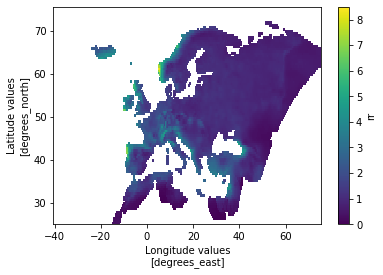

In [147]:
EOBS['rr'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}
EOBS['rr'].mean('time').plot()

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


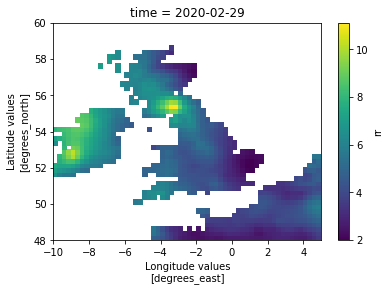

In [162]:
EOBS2020 = xr.open_dataset('../UK_example/EOBS/rr_0.25deg_day_2020_grid_ensmean.nc')
EOBS2020 = EOBS2020.resample(time='1m').mean()
EOBS2020 = EOBS2020.sel(time=EOBS2020['time.month'] == 2) ## Select only February
EOBS2020['rr'].sel(latitude=slice(48,60),longitude=slice(-10,5)).plot()


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

Text(0.5, 1.0, 'EOBS 2020')

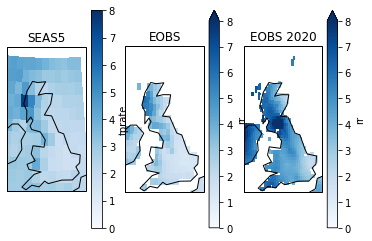

In [165]:
fig, axs = plt.subplots(1, 3,subplot_kw={'projection': ccrs.OSGB()})

SEAS5['tprate'].mean(dim = ['time','leadtime','number']).plot(transform=ccrs.PlateCarree(), vmin = 0, vmax = 8, cmap=plt.cm.Blues, ax=axs[0])  #,cmap=plt.cm.Blues,
EOBS['rr'].mean('time').plot(transform=ccrs.PlateCarree(), vmin = 0, vmax = 8, cmap=plt.cm.Blues, ax=axs[1])
EOBS2020['rr'].plot(transform=ccrs.PlateCarree(), vmin = 0, vmax = 8, cmap=plt.cm.Blues, ax=axs[2])

for ax in axs.flat:
    ax.coastlines(resolution='110m')
    
axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')
axs[2].set_title('EOBS 2020')

In [167]:
EOBS2020
EOBS
(EOBS2020['rr']-EOBS['rr'].mean('time'))
# /EOBS['rr'].std('time')


<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 464, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2020-02-29
  * longitude  (longitude) float64 -40.38 -40.12 -39.88 ... 74.88 75.12 75.38
  * latitude   (latitude) float64 25.38 25.62 25.88 26.12 ... 74.88 75.12 75.38
Data variables:
    rr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 232, time: 68)
Coordinates:
  * time       (time) datetime64[ns] 1950-02-28 1951-02-28 ... 2017-02-28
  * longitude  (longitude) float32 -40.25 -39.75 -39.25 ... 74.25 74.75 75.25
  * latitude   (latitude) float32 25.25 25.75 26.25 26.75 ... 74.25 74.75 75.25
Data variables:
    rr         (time, latitude, longitude) float32 nan nan nan ... nan nan nan

<xarray.DataArray 'rr' (time: 1, latitude: 0, longitude: 0)>
array([], shape=(1, 0, 0), dtype=float32)
Coordinates:
  * latitude   (latitude) float64 
  * longitude  (longitude) float64 
  * time       (time) datetime64[ns] 2020-02-29

TypeError: slice expected at least 1 argument, got 0

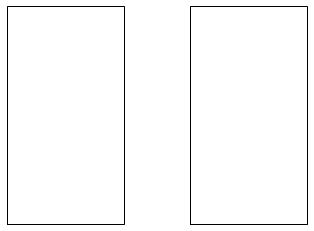

In [149]:
fig, axs = plt.subplots(1, 2,subplot_kw={'projection': ccrs.OSGB()})

(SEAS5['tprate'].mean(dim = ['time','leadtime','number'])
 .sel(latitude=slice(),longitude=slice())
 .plot(transform=ccrs.PlateCarree(), vmin = 0, vmax = 8, cmap=plt.cm.Blues, ax=axs[0]))  #,cmap=plt.cm.Blues,
EOBS['rr'].mean('time').plot(transform=ccrs.PlateCarree(), vmin = 0, vmax = 8, cmap=plt.cm.Blues, ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='110m')
    
axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')

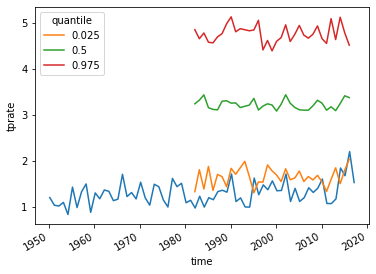

In [152]:
# np.arange('1950', '2017', dtype='datetime64[Y]')
EOBS['rr'].mean(dim = ['latitude','longitude']).plot(x='time')

Quantiles = SEAS5['tprate'].mean(dim = ['latitude','longitude']).quantile([2.5/100, 0.5, 97.5/100], dim=['number','leadtime'])
Quantiles.plot.line(x='time')

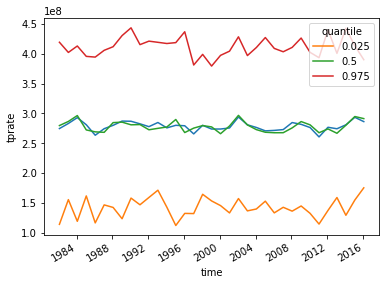

In [111]:
# SEAS5['tprate'].mean(dim = ['latitude','longitude','number','leadtime']).plot.line(x = 'time')
Quantiles = SEAS5['tprate'].mean(dim = ['latitude','longitude']).quantile([2.5/100, 0.5, 97.5/100], dim=['number','leadtime'])
Quantiles.plot.line(x='time')
# plt.plot(Quantiles.sel(quantile=0.5),label = 'SEAS5 Median')
# plt.fill_between(Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975), color='green', alpha=0.2,label = '97.5% percentile')

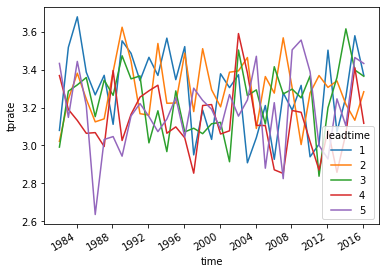

In [95]:
SEAS5['tprate'].mean(dim = ['latitude','longitude','number']).plot.line(x = 'time')


In [ ]:
Quantiles = Tapajos.assign_coords(time=np.tile(time_year,400)).groupby("time.month").quantile([2.5/100, 0.5, 97.5/100, 99/100, 0.999, 0.9999], dim="time")
plt.plot(np.arange(1,13), Quantiles.sel(quantile=0.5),label = 'Median of 2000 years')
plt.fill_between(np.arange(1,13), Quantiles.sel(quantile=0.025), Quantiles.sel(quantile=0.975), color='green', alpha=0.2,label = '97.5% percentile')